# Principal Component Analysis of Gravitational Waves from Rotating Stellar Core Collapse

Based on published work:

* Abdikamalov, Gossan, DeMaio, & Ott, *Measuring the angular momentum distribution in core-collapse supernova progenitors with gravitational waves*, Phys. Rev. D. 90, 044001 (2014), http://adsabs.harvard.edu/abs/2014PhRvD..90d4001A

* Engels, Frey, & Ott, *Multivariate regression analysis of gravitational waves from rotating core collapse*, Phys. Rev. D. 90, 124026 (2014), http://adsabs.harvard.edu/abs/2014PhRvD..90l4026E

* Logue, Ott, Heng, Kalmus, Scargill, *Inferring core-collapse supernova physics with gravitational waves*, Phys. Rev. D. 86, 044023 (2012), http://adsabs.harvard.edu/abs/2012PhRvD..86d4023L

* Heng, *Rotating stellar core-collapse waveform decomposition: a principal component analysis approach*, Class. Quantum Grav. 26, 105005 (2009)


## Background

<b>Stellar Collapse & Core-Collapse Supernova Schematic</b>

<img src="ccsn.png" width="45%">


Much remains to be learned about the details of this process. <b>Gravitational Waves</b> -- Ripples in Spacetime first predicted by Einstein and in 2015 observed for the first time -- can help us look inside the stellar core and learn about its dynamics. If the core is rotating, then it will have a quadrupole (think: *oblate*) deformation:

<img src="rotcoll.png" width=45%>

This kind of deformation leads to the emission of a strong burst of gravitational waves when the protoneutron star first forms. Here are two example gravitational waves:

<img src="mygw.png" width=80%>

Gravitational waves from rotating core collapse share a common morphology with variations in detail. Some of the detailed variations are due to uncontrolled uncertainties (numerics, variations in input physics). <b>Can we extract the most robust features?</b> 

This is why we are considering PCA.

---
## Read and prepare the Data

Here we're reading the Abdikamalov et al. gravitational waveform catalog. We've preprocessed the waveforms. They are aligned at the maximum. There are 92 waveforms sampled at 16384 Hz, each covering a second in physical time. In the CSV, there are 92 columns with 16384 rows each. The 92d column contains the time coordinate running from -0.5 to 0.5 seconds.

In [19]:
# load our modules
%matplotlib inline
import pandas as pd # we'll use Pandas for reading the data
import numpy as np  # we'll use NumPy to do the heavy lifting
import matplotlib.pyplot as mpl # we'll use matplotlib to do the plotting

In [7]:
indata = pd.read_csv('Abdika_waveforms_cat.csv', sep=',',header=0)
myarr_in = indata.values
myarr_header = indata.columns

In [8]:
# check the shape
myarr_in.shape

(16384, 93)

In [9]:
# now get rid of the time data, store it for plotting
time = myarr_in[:,-1]
myarr = myarr_in[:,0:-1]
myarr.shape

(16384, 92)

In [10]:
# let's take a look at the header
print(myarr_header)

Index(['A1O01.0', 'A1O01.5', 'A1O02.0', 'A1O02.5', 'A1O03.0', 'A1O03.5',
       'A1O04.0', 'A1O04.5', 'A1O05.0', 'A1O05.5', 'A1O06.0', 'A1O06.5',
       'A1O07.0', 'A1O07.5', 'A1O08.0', 'A1O08.5', 'A1O09.0', 'A1O09.5',
       'A1O10.0', 'A1O10.5', 'A1O11.0', 'A1O11.5', 'A1O12.0', 'A1O12.5',
       'A1O13.0', 'A1O13.5', 'A1O14.0', 'A1O14.5', 'A1O15.0', 'A1O15.5',
       'A2O01.0', 'A2O01.5', 'A2O02.0', 'A2O02.5', 'A2O03.0', 'A2O03.5',
       'A2O04.0', 'A2O04.5', 'A2O05.0', 'A2O05.5', 'A2O06.0', 'A2O06.5',
       'A2O07.0', 'A2O07.5', 'A2O08.0', 'A2O08.5', 'A2O09.0', 'A2O09.5',
       'A2O10.0', 'A2O10.5', 'A2O11.0', 'A2O11.5', 'A3O01.0', 'A3O01.5',
       'A3O02.0', 'A3O02.5', 'A3O03.0', 'A3O03.5', 'A3O04.0', 'A3O04.5',
       'A3O05.0', 'A3O05.5', 'A3O06.0', 'A3O06.5', 'A3O07.0', 'A3O07.5',
       'A3O08.0', 'A3O08.5', 'A3O09.0', 'A3O09.5', 'A4O01.0', 'A4O01.5',
       'A4O02.0', 'A4O02.5', 'A4O03.0', 'A4O03.5', 'A4O04.0', 'A4O04.5',
       'A4O05.0', 'A4O05.5', 'A4O06.0', 'A4O06.5', 

The Abdikamalov et al. simulations are identified by degree of differential rotation A and initial angular velocity of the core O (for $\Omega$). A runs from A1 (most differential) through A5 (least differential) and O goes from $0.1\,\mathrm{rad\,s}^{-1}$ through at most $15.5\,\mathrm{rad\,s}^{-1}$.

---
## Taking a look

(-0.015, 0.025)

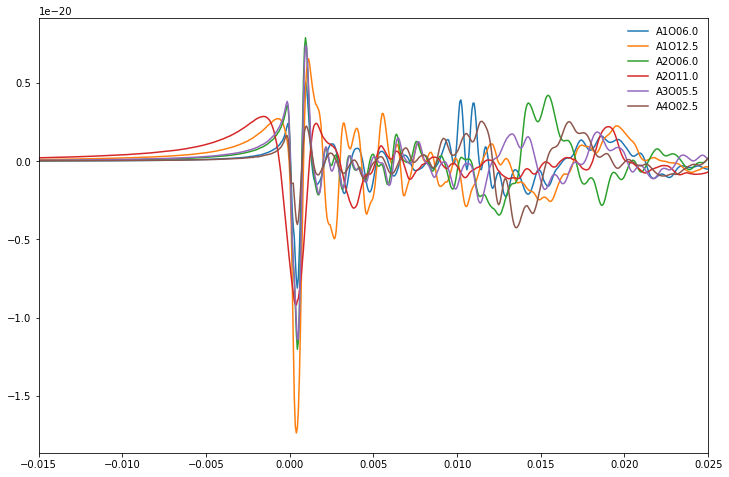

In [91]:
# let's plot some waveforms!
nw = 92
mpl.figure(figsize=(12,8))
pw = [10,23,40,50,61,73]
for iwf in pw:
    label = myarr_header[iwf]
    mpl.plot(time,myarr[:,iwf],label=label)
mpl.legend(frameon=False)
mpl.xlim(-0.015,0.025)


---
## Theory: PCA

PCA allows us to extract the most prominent features common to all waveforms.

### The brute force way

The simplest, but not necessarily most efficient way is to compute the covariance matrix $\mathbf{C}$. 
The eigenvectors of $\mathbf{C}$, ordered by the size of their associated eigenvalues, are then the principal components of our dataset.

Some definitions:

$$ \begin{array}{ll}{N = \text{number of data samples -- 16384}} \\
{M = \text{number of waveforms in the catalog -- 92}}\end{array}$$


Let $\mathbf{G}$ be our original $N \times M$ matrix. Each column $G_j$ of $\mathbf{G}$ corresponds to one waveform. We now define the $N \times M$ matrix $\mathbf{X}$ in such a way that each column $j$ of $\mathbf{X}$ has the mean of all columns subtracted. We say it is *centered*:

$$X_j = G_j - \frac{1}{M} \sum_{k=1}^{M} G_k $$

The covariance matrix is then given by:

$$ \mathbf{C} = \frac{1}{M-1} \mathbf{X X}^T $$ .

The unique non-zero eigenvalues of $\mathbf{C}$ have associated normalized eigenvectors that form the basis $\{e_1, e_2, ..., e_M\}$ that spans the space of waveforms. Computing the eigenvalues of $\mathbf{C}$, however, is not a good idea, since it is an $N \times N$ matrix. Recall that $N = 16384$ in our case...

### The Smarter Way: Use Singular Value Decomponsition

We factor our centered $N \times M$ matrix $\mathbf{X}$ in the following way:

$$ \mathbf{X} = \mathbf{U \Sigma V}^T\,\,, $$

where $\mathbf{U}$ is an $N \times N$ matrix whose columns correspond to the eigenvectors of $\mathbf{XX}^T$, our principal components. The columns of the $M \times M$ matrix $\mathbf{V}$ correspond to the eigenvectors of $\mathbf{X}^T \mathbf{X}$. $\mathbf{\Sigma}$ is a diagonal $N \times M$ matrix and its coefficients correspond to the square root of the corresponding eigenvalues.

We obtain $U$ by first finding the eigenvalues and eigenvectors of $\mathbf{V} = \mathbf{X}^T \mathbf{X}$,

$$\mathbf{X}^T \mathbf{X} \mathbf{v_i} = \lambda_i \mathbf{v_i}\,.$$

Multiplying both sides by $\mathbf{X}$ we have

$$\mathbf{X X}^{T} \mathbf{X} \mathbf{v_i} = \lambda_i \mathbf{X} \mathbf{v_i}\,,$$

and from this we see that $\mathbf{X \mathbf{v_i}}$ are the eigenvectors of the rescaled covariance matrix $(M - 1) \mathbf{C}$. Hence, all we need to do is find the eigenvectors of the much smaller $M \times M$ matrix $\mathbf{X}^T \mathbf{X}$.


---
## Doing it!

### Let's start with our manual SVD

In [33]:
nw = 92
nsample = 16384
# compute mean vector
meanvec = 1.0/nw*np.sum(myarr[:,:],axis=1)
# subtract mean from each column -- get the centered array
meanvec2 = meanvec.reshape(nsample,1)
myarr2, meanvec_bc = np.broadcast_arrays(myarr,meanvec2)
X = myarr - meanvec_bc

In [36]:
# get X^T X, this is M x M
XTX = np.dot(X.transpose(),X)

In [38]:
# compute eigenvalues and eigenvectors,
# this will automatically order the EVs and PCs.
w2, v2 = np.linalg.eig(XTX)

In [39]:
# get the principal components
PCs= np.dot(X,v2)

In [59]:
# normalize the PCs
PCs_norm = np.zeros( PCs.shape )
for i in range(PCs.shape[1]):
    PCs_norm[:,i] = PCs[:,i] / np.linalg.norm(PCs[:,i])

# let's also normalize the waveforms
WFs_norm = np.zeros( myarr.shape )
for i in range(myarr.shape[1]):
    WFs_norm[:,i] = myarr[:,i] / np.linalg.norm(myarr[:,i])

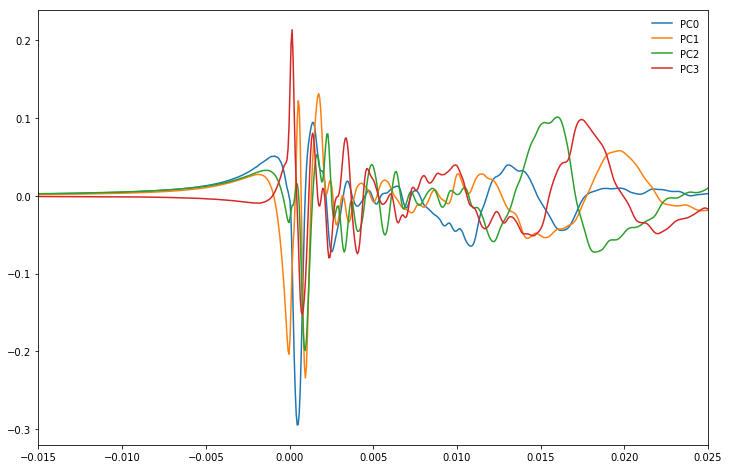

In [60]:
# Let's look at some PCs
mpl.figure(figsize=(12,8))
mpl.plot(time,PCs_norm[:,0],label="PC0")
mpl.plot(time,PCs_norm[:,1],label="PC1")
mpl.plot(time,PCs_norm[:,2],label="PC2")
mpl.plot(time,PCs_norm[:,3],label="PC3")
mpl.xlim(-0.015,0.025)
mpl.legend(frameon=False)

In [80]:
# we could also have used the built-in SVD capability in NumPy:
u,s,v = np.linalg.svd(X)

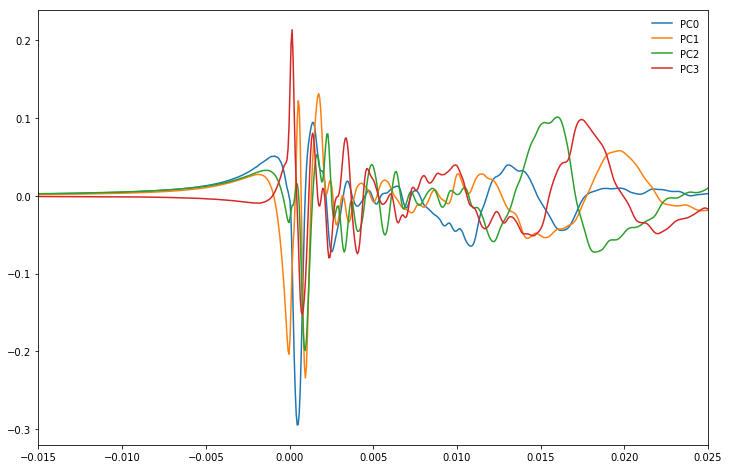

In [92]:
# Let's look at some PCs, there's some strange sign issue (minor) that requires flipping
# the sign to get the PCs order >0 to be identical with those obtained in the manual PCA.
# But this shouldn't matter for the decomposition.
mpl.figure(figsize=(12,8))
mpl.plot(time,u[:,0],label="PC0")
mpl.plot(time,-u[:,1],label="PC1")
mpl.plot(time,-u[:,2],label="PC2")
mpl.plot(time,-u[:,3],label="PC3")
mpl.xlim(-0.015,0.025)
mpl.legend(frameon=False)

## How efficient is our PC decomposition?

To evaluate this, we define the match parameter. Let $G_i$ be a waveform and $e_j$ a PC. We define the match parameter for waveform $i$, $\mu_i$, as

$$ \mu_i = \left|\left| \sum_{j=1}^Z \langle G_i|e_j\rangle e_j \right|\right|\,, $$

where $\langle \cdot | \cdot \rangle$ is an inner product, $||\cdot ||$ denotes a norm, and $Z \le M$. Ideally, we want to achieve a high $\mu_i$ for a $Z \ll M$. If the waveforms $G_i$ themselves are normalized, then for $Z=M$, $\mu_i = 1$. $\mu$ was introduced by Heng (2009).

In [61]:
# match parameter function
def match(WFn,PCsn,npcs):
    myvec = np.zeros(len(WFn[:]))
    for j in range(npcs):
        # scalar product
        coeff = np.dot(WFn,PCsn[:,j])
        myvec += coeff*PCsn[:,j]
    mu = np.linalg.norm(myvec)
    return mu

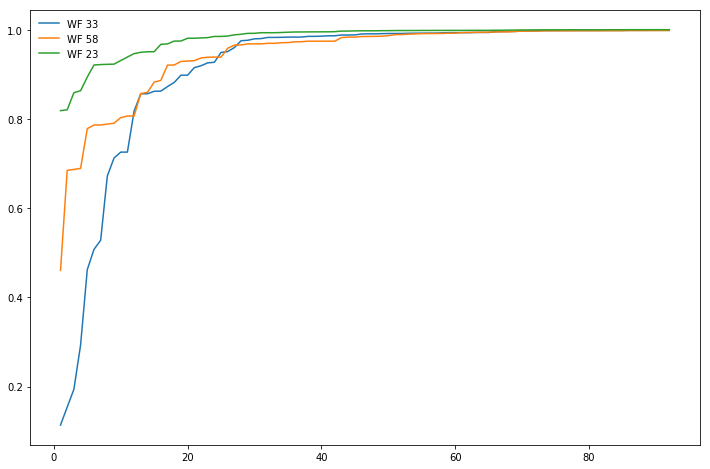

In [71]:
# let's look at this for some random waveform. Say #33 and let's vary Z from 1 to M
WF = WFs_norm[:,33]
Zvalues = np.linspace(1,nw,nw,dtype=np.int)
mus = np.zeros(nw)
for i in range(nw):
    mus[i] = match(WF,PCs_norm,Zvalues[i])

mpl.figure(figsize=(12,8))
mpl.plot(Zvalues,mus, label="WF 33")    
    
WF = WFs_norm[:,58]
Zvalues = np.linspace(1,nw,nw,dtype=np.int)
mus = np.zeros(nw)
for i in range(nw):
    mus[i] = match(WF,PCs_norm,Zvalues[i])
    
mpl.plot(Zvalues,mus, label="WF 58")    
    
WF = WFs_norm[:,23]
Zvalues = np.linspace(1,nw,nw,dtype=np.int)
mus = np.zeros(nw)
for i in range(nw):
    mus[i] = match(WF,PCs_norm,Zvalues[i])
    
mpl.plot(Zvalues,mus, label="WF 23")    

mpl.legend(frameon=False)
    

In [72]:
# we can also visualize the minimum match as a function of Z
Zvalues = np.linspace(1,nw,nw,dtype=np.int)
mu_min = np.zeros(nw)
for i in range(nw):
    mus = np.zeros(nw)
    for j in range(nw):
        mus[j] = match(WFs_norm[:,j],PCs_norm,Zvalues[i])
    mu_min[i] = np.min(mus)

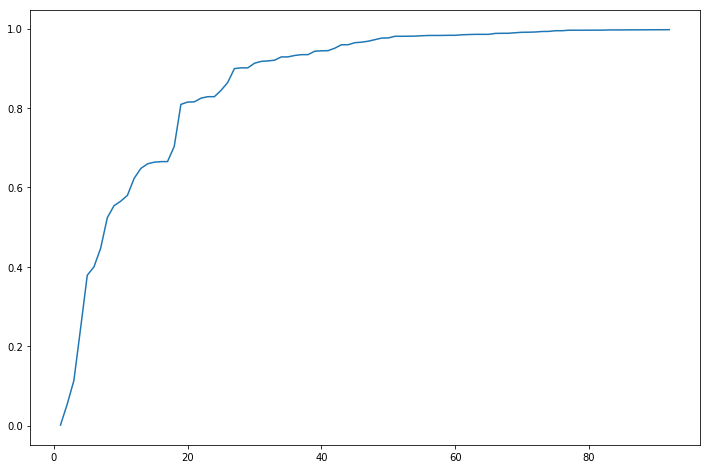

In [88]:
mpl.figure(figsize=(12,8))
mpl.plot(Zvalues,mu_min)